In [ ]:
######################## Linear regression ########################

In [36]:
# Required modules
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
import statistics
import statsmodels.api as sm
register_matplotlib_converters()

In [2]:
conn = sqlite3.connect("stocks-updated.db")
df = pd.read_sql("SELECT * FROM eow",conn, parse_dates='date')
df.head()

,symbol,date,adjclose,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,...,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_wr,momentum_ao,momentum_roc,logret,slogret,sadjclose
0,A,2011-01-14,28.4382,17917600.0,1.741094e+07,40957700.0,0.425096,2.938486e+07,9.249562,9.249562,...,100.000000,50.0,-97.449707,5.335547,-6.224066,0.000000,0.0,0.038648,-0.026944,27.6822
1,A,2011-01-21,27.6822,21525200.0,5.244519e+06,19432500.0,0.083935,2.165074e+07,8.334417,8.791990,...,56.974880,50.0,-96.539337,6.290787,-67.826087,0.000000,0.0,-0.026944,-0.027200,26.9394
2,A,2011-01-28,26.9394,22294000.0,-1.536054e+07,-2861500.0,-0.181188,1.495889e+07,-8.940522,2.881152,...,39.150210,50.0,-96.059313,6.168388,-97.198880,0.000000,0.0,-0.027200,0.047882,28.2607
3,A,2011-02-04,28.2607,27637800.0,9.608781e+06,24776300.0,0.085476,2.075790e+07,-5.456295,0.796790,...,61.952107,50.0,-94.765733,10.705823,-34.597156,0.000000,0.0,0.047882,0.046140,29.5952
4,A,2011-02-11,29.5952,27674300.0,3.449420e+07,52450600.0,0.246231,2.581804e+07,20.323549,4.702142,...,72.968992,50.0,-93.029797,14.361406,-2.642276,0.173408,0.0,0.046140,-0.024736,28.8721


In [3]:
# Set date and symbol as index
df['company'] = df['symbol']
df.set_index(keys= "symbol", inplace = True, append=False)
df.set_index(keys= "date", inplace = True, append=True)
df.head()

adjclose      volume    volume_adi  volume_obv  volume_cmf  \
symbol date                                                                     
A      2011-01-14   28.4382  17917600.0  1.741094e+07  40957700.0    0.425096   
       2011-01-21   27.6822  21525200.0  5.244519e+06  19432500.0    0.083935   
       2011-01-28   26.9394  22294000.0 -1.536054e+07  -2861500.0   -0.181188   
       2011-02-04   28.2607  27637800.0  9.608781e+06  24776300.0    0.085476   
       2011-02-11   29.5952  27674300.0  3.449420e+07  52450600.0    0.246231   

                      volume_fi  volume_em  volume_sma_em    volume_vpt  \
symbol date                                                               
A      2011-01-14  2.938486e+07   9.249562       9.249562 -1.134284e+07   
       2011-01-21  2.165074e+07   8.334417       8.791990  1.338134e+05   
       2011-01-28  1.495889e+07  -8.940522       2.881152 -1.170462e+06   
       2011-02-04  2.075790e+07  -5.456295       0.796790  7.573396e+05   
       2011-02-11  2.581804e+07  20.323549       4.702142  2.662376e+06   

                    volume_nvi  ...  momentum_mfi  momentum_tsi  momentum_uo  \
symbol date                     ...                                            
A      2011-01-14  1039.404133  ...          50.0    -97.449707     5.335547   
       2011-01-21  1039.404133  ...          50.0    -96.539337     6.290787   
       2011-01-28  1039.404133  ...          50.0    -96.059313     6.168388   
       2011-02-04  1039.404133  ...          50.0    -94.765733    10.705823   
       2011-02-11  1039.404133  ...          50.0    -93.029797    14.361406   

                   momentum_wr  momentum_ao  momentum_roc    logret   slogret  \
symbol date                                                                     
A      2011-01-14    -6.224066     0.000000           0.0  0.038648 -0.026944   
       2011-01-21   -67.826087     0.000000           0.0 -0.026944 -0.027200   
       2011-01-28   -97.198880     0.000000           0.0 -0.027200  0.047882   
       2011-02-04   -34.597156     0.000000           0.0  0.047882  0.046140   
       2011-02-11    -2.642276     0.173408           0.0  0.046140 -0.024736   

                   sadjclose  company  
symbol date                            
A      2011-01-14    27.6822        A  
       2011-01-21    26.9394        A  
       2011-01-28    28.2607        A  
       2011-02-04    29.5952        A  
       2011-02-11    28.8721        A  

[5 rows x 40 columns]

In [5]:
def add_response_var(colname, lag):
    y = df.groupby("company")[colname].apply(lambda x: x - x.shift(lag))
    df["response"] = y
    df.dropna(axis=0, inplace =True)
    return


In [25]:
def tt_split(stock, split_ind):
    """
    Performs tt split
    """
    sto = df.loc[stock]
    xtr = sto.iloc[:split_ind,:-4]
    ytr = sto["response"].iloc[:split_ind]
    xte = sto.iloc[split_ind+1:,:-4]
    yte = sto["response"].iloc[split_ind+1:]
    return xtr, ytr, xte, yte


In [51]:
def run_lr_and_predict(xtr, ytr, xte, yte):
    """
    Runs OLS reg and returns summary and predicted variables given test set
    """
    model = sm.OLS(ytr, xtr).fit()
    train_pred = model.predict(xtr)
    test_pred = model.predict(xte)
    train_mse = np.square(np.subtract(ytr, train_pred)).mean()
    test_mse = np.square(np.subtract(yte, test_pred)).mean()
    return model, model.summary(), train_pred, test_pred, {"train_mse": train_mse, "test_mse": test_mse}

In [33]:
def plot_lm(actual, prediction):
    """
    Prints Linear regression plots
    """
    fig_size1 = plt.rcParams["figure.figsize"]
    fig_size1[0] = 20
    fig_size1[1] = 10
    plt.rcParams["figure.figsize"] = fig_size1
    plt.plot(actual,  color='red')
    plt.plot(prediction, color='green')
    plt.show()
    return

In [ ]:
#########################################################################

In [ ]:
# Add response variable
add_response_var(colname="adjclose", lag=4)
df.head()

In [26]:
# Get test and train data
xtr, ytr, xte, yte = tt_split(stock="AAPL", split_ind=400)

In [52]:
# Fit the model and predict
model, summary, train_pred, test_pred, mse = run_lr_and_predict(xtr, ytr, xte, yte)

In [53]:
# Model Summary
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               response   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.690
Method:                 Least Squares   F-statistic:                              25.71
Date:                Wed, 20 Nov 2019   Prob (F-statistic):                    6.62e-79
Time:                        13:02:01   Log-Likelihood:                         -1097.4
No. Observations:                 400   AIC:                                      2267.
Df Residuals:                     364   BIC:                                      2411.
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
adjclose                    0.0760      0.023      3.356      0.001       0.031       0.121
volume                  -4.125e-09   1.98e-09     -2.080      0.038   -8.03e-09   -2.25e-10
volume_adi               2.935e-10   7.07e-10      0.415      0.678    -1.1e-09    1.68e-09
volume_obv               -2.82e-10   2.82e-10     -0.998      0.319   -8.37e-10    2.73e-10
volume_cmf                  2.0560      3.231      0.636      0.525      -4.299       8.411
volume_fi               -1.605e-10   2.46e-10     -0.653      0.514   -6.43e-10    3.23e-10
volume_em                  -0.0181      0.005     -3.544      0.000      -0.028      -0.008
volume_sma_em               0.0303      0.012      2.473      0.014       0.006       0.054
volume_vpt                3.97e-09   1.26e-08      0.314      0.754   -2.09e-08    2.88e-08
volume_nvi              -5.928e-05      0.000     -0.538      0.591      -0.000       0.000
volatility_atr              0.3743      0.135      2.768      0.006       0.108       0.640
volatility_bbl              0.0095      0.008      1.219      0.224      -0.006       0.025
volatility_bbm              0.0110      0.021      0.528      0.598      -0.030       0.052
volatility_dcl             -0.0151      0.020     -0.760      0.448      -0.054       0.024
trend_macd_diff             0.2281      0.120      1.907      0.057      -0.007       0.463
trend_adx                   0.0187      0.038      0.497      0.619      -0.055       0.093
trend_adx_pos               0.3949      0.115      3.436      0.001       0.169       0.621
trend_adx_neg              -0.1196      0.063     -1.904      0.058      -0.243       0.004
trend_vortex_ind_neg        7.7733      3.451      2.252      0.025       0.987      14.560
trend_mass_index           -0.6783      0.241     -2.818      0.005      -1.152      -0.205
trend_cci                   0.0381      0.005      7.293      0.000       0.028       0.048
trend_dpo                  -0.0002      0.007     -0.024      0.981      -0.013       0.013
trend_kst_sig               0.0027      0.003      0.882      0.379      -0.003       0.009
trend_kst_diff             -0.0224      0.008     -2.923      0.004      -0.037      -0.007
trend_ichimoku_b           -0.0010      0.007     -0.138      0.891      -0.015       0.013
trend_visual_ichimoku_b    -0.0076      0.005     -1.476      0.141      -0.018       0.003
trend_aroon_up             -0.0159      0.009     -1.709      0.088      -0.034       0.002
trend_aroon_down            0.0058      0.009      0.660      0.510      -0.011       0.023
trend_aroon_ind            -0.0216      0.005     -4.170      0.000      -0.032      -0.011
momentum_rsi                0.1338      

In [47]:
# Mean squared error
mse

{'train_mse': 14.145047357664446, 'test_mse': 190.84721509969276}

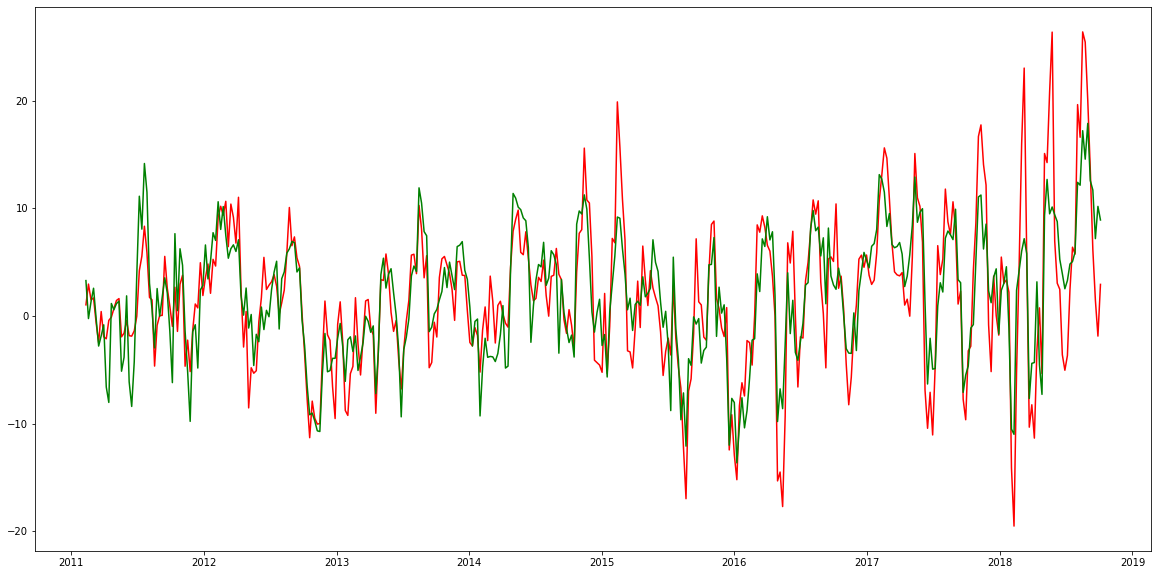

In [39]:
# Plot train
plot_lm(actual=ytr, prediction=train_pred)

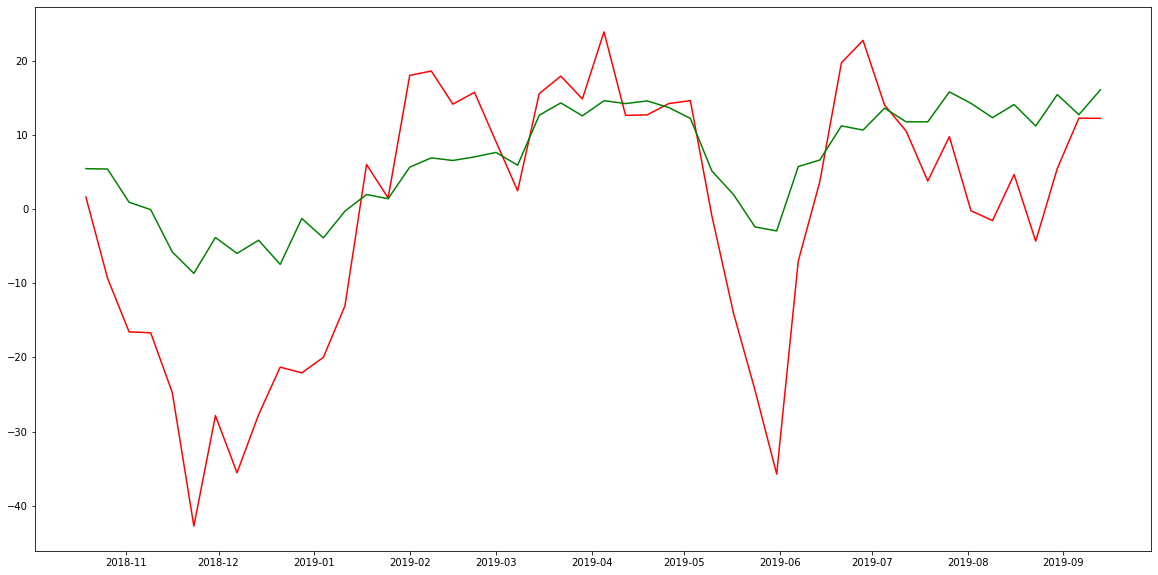

In [40]:
# Plot test
plot_lm(actual=yte, prediction=test_pred)

In [ ]:
#####################################################################